In [3]:
# tf.test.gpu_device_name()
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu 
# !pip install tf-nightly

In [4]:
tf.test.gpu_device_name()

NameError: name 'tf' is not defined

In [31]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [32]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [33]:
NUM_CLASSES = 11 #increment when adding the gestures

# import os
# from keypoint_csv_from_video import dirname

# csv_path_keypoint = os.path.join(dirname, 'model/keypoint_classifier/keypoint.csv')
# with open(csv_path_keypoint, "r") as scraped:
#         NUM_CLASSES = int(scraped.readlines()[-1].split(',')[0])+1

# print(NUM_CLASSES)

# Dataset reading

In [34]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))   

In [35]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [38]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 11)                121       
                                                                 
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [40]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [41]:
history=model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback,es_callback]
)

Epoch 1/1000
12/17 [====================>.........] - ETA: 0s - loss: 2.4347 - accuracy: 0.0742 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
17/17 [==============================] - 1s 22ms/step - loss: 2.4229 - accuracy: 0.0827 - val_loss: 2.3610 - val_accuracy: 0.0029
Epoch 2/1000
 1/17 [>.............................] - ETA: 0s - loss: 2.3737 - accuracy: 0.1016
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
17/17 [==============================] - 0s 8ms/step - loss: 2.3666 - accuracy: 0.1224 - val_loss: 2.3147 - val_accuracy: 0.2106
Epoch 3/1000
 1/17 [>.............................] - ETA: 0s - loss: 2.2930 - accuracy: 0.2969
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
17/17 [==============================] - 0s 10ms/step - loss: 2.3177 - accuracy: 0.2033 - val_loss: 2.2584 - val_accuracy: 0.3438
Epoch 4/1000
13/17 [=====================>........] - ETA: 0s - loss: 2.2623 - accuracy: 0.235

In [42]:
import matplotlib.pyplot as plt

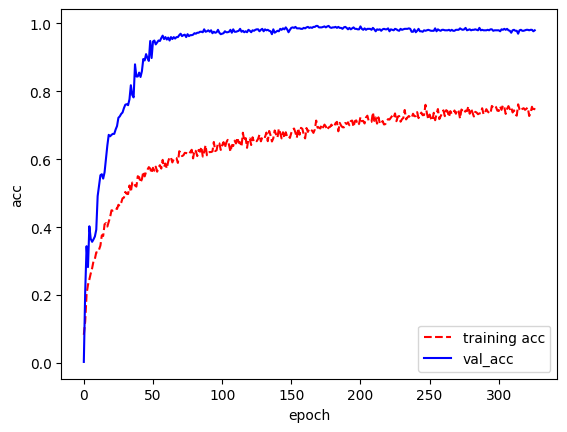

In [43]:


accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(len(accuracy))
plt.plot(epochs, accuracy,"r--")
plt.plot(epochs, val_accuracy,"b")
plt.legend(['training acc','val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

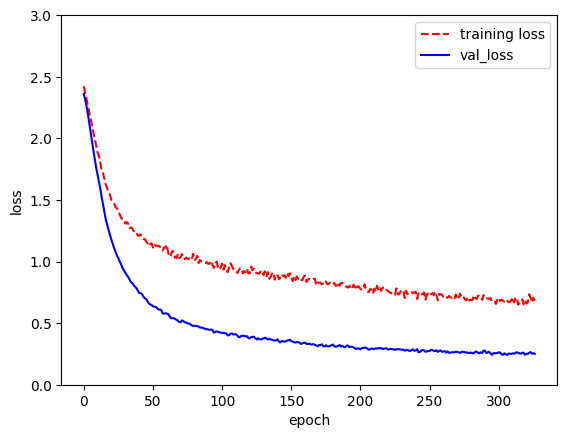

In [44]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss,"r--")
plt.plot(epochs, val_loss,"b")
plt.legend(['training loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,3)
plt.show()

In [45]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

6/6 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9799


In [46]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [47]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 104ms/step
[2.93296695e-01 1.81020569e-05 6.39168575e-05 4.99593443e-04
 7.03967154e-01 5.71045344e-09 1.01554338e-04 4.92325693e-04
 1.01194055e-05 1.55040715e-03 3.49403735e-11]
4


# Confusion matrix

22/22 [==============================] - 0s 2ms/step


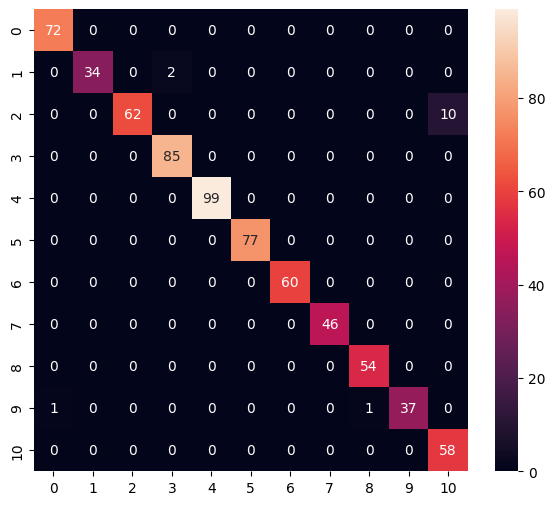

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.94      0.97        36
           2       1.00      0.86      0.93        72
           3       0.98      1.00      0.99        85
           4       1.00      1.00      1.00        99
           5       1.00      1.00      1.00        77
           6       1.00      1.00      1.00        60
           7       1.00      1.00      1.00        46
           8       0.98      1.00      0.99        54
           9       1.00      0.95      0.97        39
          10       0.85      1.00      0.92        58

    accuracy                           0.98       698
   macro avg       0.98      0.98      0.98       698
weighted avg       0.98      0.98      0.98       698



In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [49]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [50]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\irene\AppData\Local\Temp\tmpl3ghl8b1\assets


INFO:tensorflow:Assets written to: C:\Users\irene\AppData\Local\Temp\tmpl3ghl8b1\assets


6880

# Inference test

In [51]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [52]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [53]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [54]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [55]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.93296695e-01 1.81020732e-05 6.39168647e-05 4.99593909e-04
 7.03967154e-01 5.71045256e-09 1.01554324e-04 4.92326391e-04
 1.01194246e-05 1.55040843e-03 3.49403666e-11]
4
